# Initial Analysis of ITC Prompt

## Important Takeaways from Prompt:

- 4th highest annual ridership for commuter rail outside of Amtrak's Northeast Corridor.
- 20% bicylce mode share ([1% national average for reference](https://bikeleague.org/wp-content/uploads/bfareportcards/bfs/2017/california.pdf))
  - Should probably focus on either adding or working with existing biking infrastructure
- 4 million annual bus ridership (Unitrans)

In [5]:
# Load in directories
import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
from utils import plot_crashes_by_category, ll_to_xy, radius_label, aoi_dashboard


## Traffic Analysis

The first segment of this notebook will be on crash analysis. This includes loading in data from TIMS and seeing what crashes occured in our **Area of Interest (AOI)** based on the main project prompt. Since a lot of the times the AOI doesn't give a full look on the incidents in the area, we will look slightly around the area as well (0.5-2 mile radius search).

Then we will analyze the type of crashes that occured to influence future designs / plans.

In [6]:
### Davis Jurisdictional Boundaries ###
davis_gdf = gpd.read_file(
    "data/Yolo_County_Open_Data_Street_Centerlines_-2417930449303182445.geojson"
)
if davis_gdf.crs != "EPSG:4326":
    davis_gdf = davis_gdf.to_crs(4326)

#### Crashes Data (GIS & Qualative / Quantative) ###
crash_data = pd.read_csv("data/davis_crashes.csv")
crash_gdf = gpd.GeoDataFrame(
    crash_data,
    geometry=gpd.points_from_xy(crash_data["LONGITUDE"], crash_data["LATITUDE"]),
    crs="EPSG:4326",
)

### Area of Interest for Project Prompt ###
# this is copy & pasted from Lat-Lon format in Google Maps
top_left = (38.543680985703226, -121.7440795432951)
top_right = (38.545050789861584, -121.73714115854816)
bottom_right = (38.54333958192836, -121.73654298866767)
bottom_left = (38.54217103842081, -121.74365700939322)

# Convert (lat, lon) → (lon, lat)
aoi_poly_ll = Polygon(
    [
        ll_to_xy(top_left),
        ll_to_xy(top_right),
        ll_to_xy(bottom_right),
        ll_to_xy(bottom_left),
        ll_to_xy(top_left),
    ]
)

aoi = gpd.GeoDataFrame(geometry=[aoi_poly_ll], crs="EPSG:4326").to_crs("EPSG:3310")


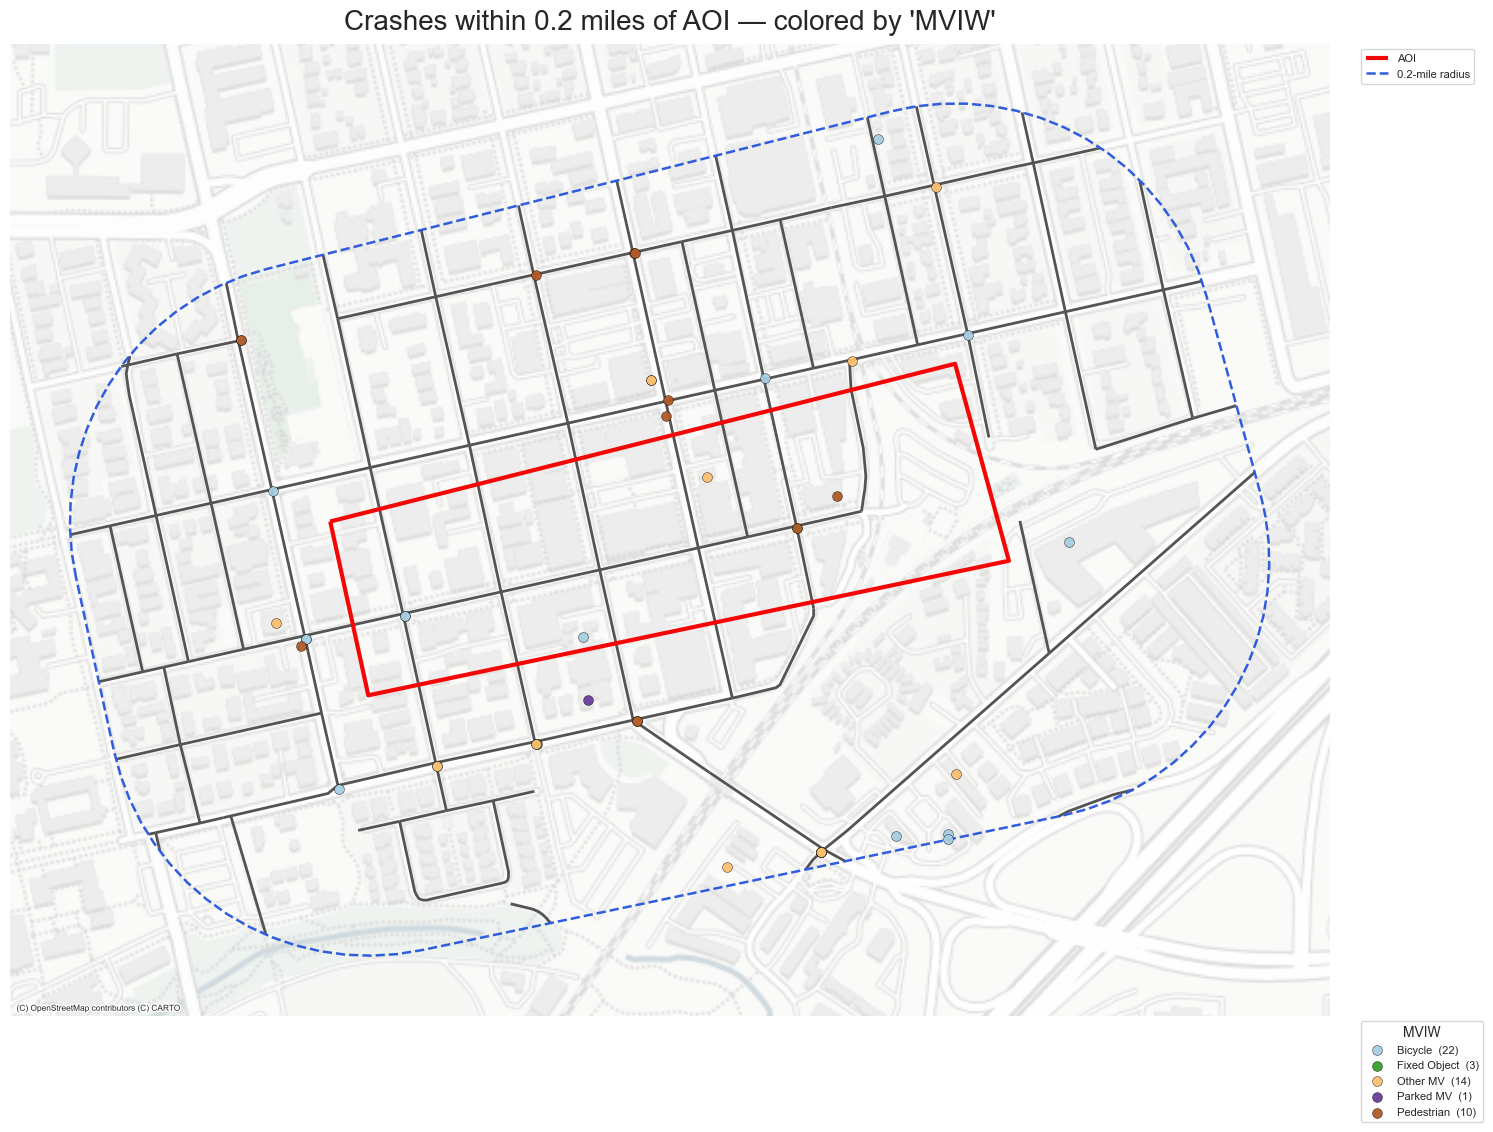

Crashes within 0.2 miles: 50


MVIW
G    22
C    14
B    10
I     3
E     1
Name: count, dtype: int64

In [7]:
# === Search for crashes within given radius and plot ===
SEARCH_RADIUS = 1/5  # miles (change to whatever you want)
lbl = radius_label(SEARCH_RADIUS)
category_col = "MVIW"

# --- Run analysis + plot ---
crashes_in_radius = plot_crashes_by_category(
    crashes_df=crash_gdf,  # your TIMS data
    aoi_gdf=aoi,  # AOI polygon
    category_col=category_col,
    radius_miles=SEARCH_RADIUS,
    filter_i80=True,  # exclude I-80 and ramps
    centerlines_gdf=davis_gdf,
    save_path=f"figures/crashes_by_{category_col.lower()}_{lbl}mi.png",
)

# Quick summary
print(f"Crashes within {SEARCH_RADIUS} miles: {len(crashes_in_radius)}")
display(crashes_in_radius[category_col].value_counts().head())

# Save filtered subset for GIS / later analysis
crashes_in_radius.to_file(f"outputs/crashes_within_{lbl}mi.geojson", driver="GeoJSON")

# Export category counts as CSV (if you want to analyze)
# (
#     crashes_in_radius[category_col]
#     .value_counts()
#     .rename_axis(category_col)
#     .reset_index(name="count")
#     .to_csv(f"outputs/counts_{category_col.lower()}_{lbl}mi.csv", index=False)
# )


### Crashes within n-Mile EDA

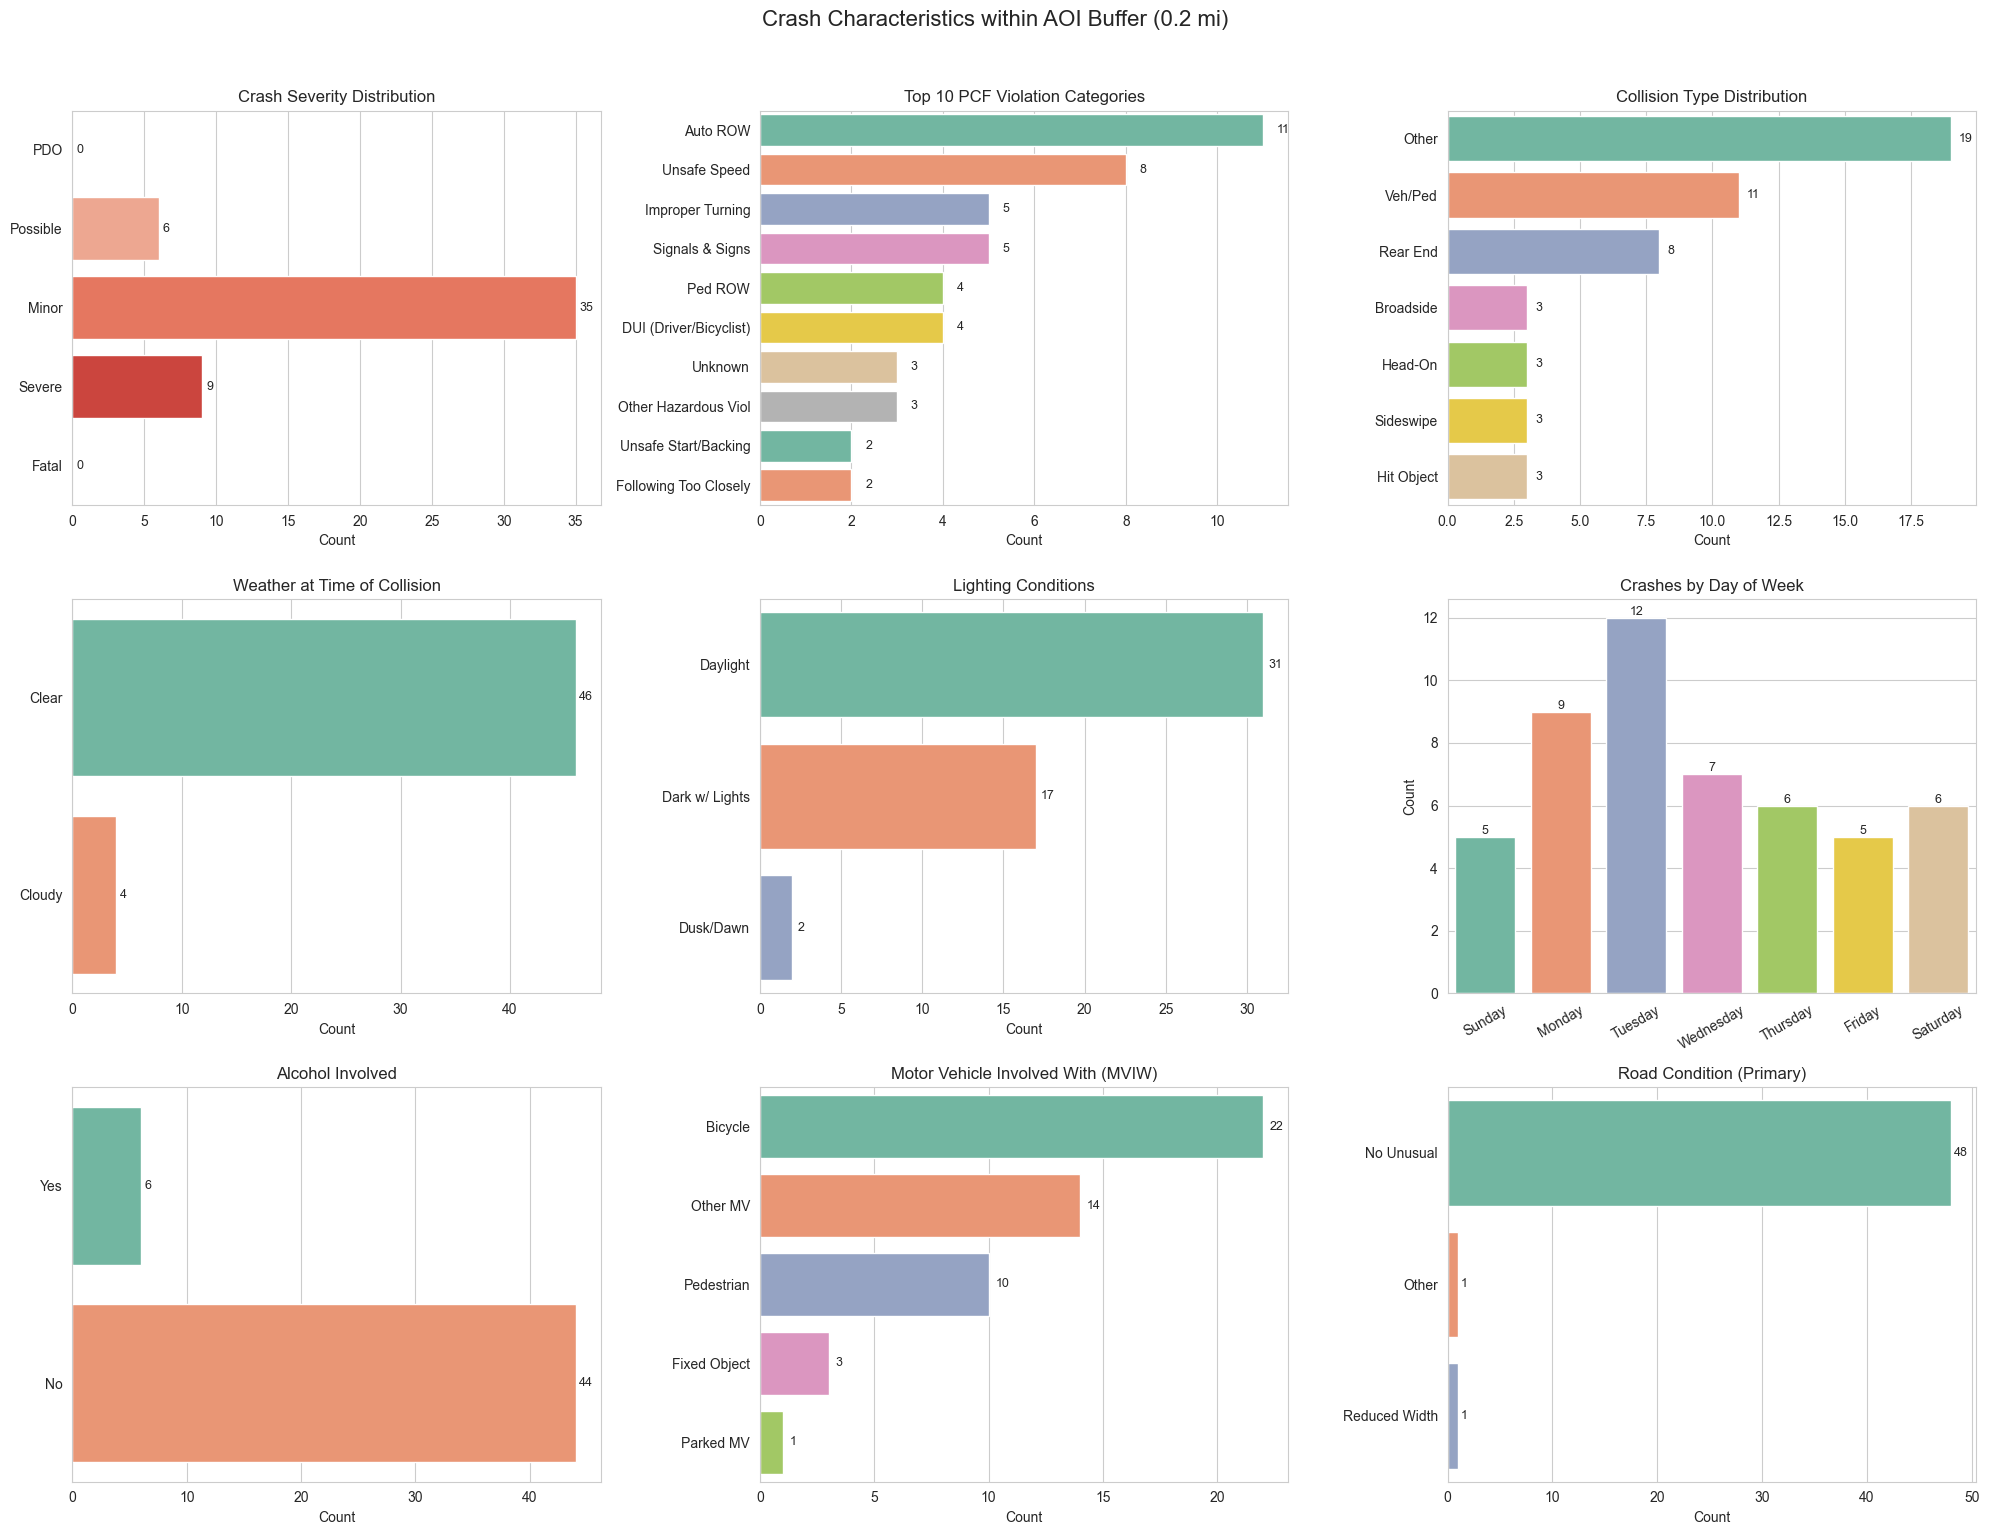

In [8]:
_ = aoi_dashboard(
    crashes_gdf=crashes_in_radius,
    title=f"Crash Characteristics within AOI Buffer ({SEARCH_RADIUS} mi)",
    top_n_pcfcat=10,
    save_path=f"figures/aoi_dashboard_{lbl}mi.png",
)
